### ESTOU ME BASEANDO QUE A VARIÁVEL TARGET SEJA A VARIÁVEL rv1.

Importando bibliotecas que serão utilizadas durante o desenvolvimento.

In [29]:
import warnings
warnings.filterwarnings('ignore')

import sys

# Bibliteca para Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para Manipulação de Dados
import pandas as pd
import numpy as np

# Biblioteca para Análise e modelagem de séries temporais
from statsmodels.tsa.seasonal import seasonal_decompose

# Imports para formatação dos gráficos
import matplotlib.cbook
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

# Imports para criação e validação dos modelos temporais
from statsmodels.tsa.arima_model import ARIMA
import sklearn
from sklearn.metrics import mean_squared_error 
import itertools

# Import para Padronização dos dados
from sklearn.preprocessing import StandardScaler

# Import utilizado para Feature Selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

# Import utilizado para análise de MultiColinearidade dos Dados
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import para Análise de Estacionaridade nos Modelos de Séries Temporais
from statsmodels.tsa.stattools import adfuller

# Import para obter os feriados usados no Modelo SARIMAX Exógeno
import holidays

# Import Modelo de Séries Temporais Multivariado
from statsmodels.tsa.vector_ar.var_model import VAR

# Imports para o modelo Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# Import para aplicar Cross Validation
from sklearn.model_selection import cross_val_score

# Import para definir os KFold do CV
from sklearn.model_selection import RepeatedKFold

# Import para Otimização de HiperParametros
from sklearn.model_selection import GridSearchCV

# Import para o modelo de Regressão Linear
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
matplotlib.style.use('ggplot')

%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -a "Versão pacotes utilizados" --iversions

pandas          1.0.4
numpy           1.18.4
sklearn         0.23.1
seaborn         0.10.1
matplotlib      3.2.1
statsmodels.api 0.11.1
Versão pacotes utilizados


In [3]:
# Import Dataset de Treino.
df_train = pd.read_csv('dataset_training.csv')
df_test = pd.read_csv('dataset_testing.csv')

In [4]:
# Unificando o df_train e df_test pois lá na frente iremos utilizar séries temporais e os dados a serem previstos 
# devem ser os mais atuais possível.
df_full = pd.concat([df_train, df_test])
df_full = df_full.sort_values(['date'], ascending=True)
df_full.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
0,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,63000,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday


# Análise Exploratória

In [5]:
df_train.shape

(14803, 32)

In [6]:
df_test.shape

(4932, 32)

In [7]:
df_full.shape

(19735, 32)

T > Temperatura

RH >  Umidade Relativa (Relative Humidity)

T_out > Temperatura do lado de fora da casa

RH_out > Umidade do lado de fora da casa

mm_hg > Unidade de pressão

In [8]:
# Considerando a variável rv1 como a TARGET do dataset
column_target = 'rv1'

In [9]:
# Analisando as informações de cada dado
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19735 entries, 0 to 14802
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [10]:
# Resumo estatístico dos dados
df_full.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,42907.129465
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,24940.020831
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,21600.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,43200.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,64200.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,85800.000000


###### Os dados estão todos em Escalas diferentes um do outro. Isso dificulta o treinamento de alguns modelos.
###### Irei aplicar a Padronização dos dados de modo que a média de todos os dados se aproximem o máximo de 0 e o desvio padrão como 1.

### Primeiras manipulações no Dataset Treino

In [11]:
def formata_dados(dataset):
    # Convertendo a coluna date para o formato DateTime
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d %H:%M:%S')
     
    # Aplicando o Split de alguns dados do campo Date  Obs.: O Campo Day_of_week vai ser transformado em inteiro.
    dataset['Month'] = dataset['date'].dt.month
    dataset['day'] = dataset['date'].dt.day
    dataset['hour'] = dataset['date'].dt.hour
    dataset['Day_of_week'] = dataset['date'].dt.dayofweek

    # Renomeando a variável WeekStatus para Weekend. Essa variável terá valores 0 e 1. {0 : Weekday , 1: Weekend}
    dataset.rename(columns={'WeekStatus':'Weekend'}, inplace=True)

    # Segunda Feira = 0 ... Sabado = 5, Domingo = 6
    dataset['Weekend'] = 0
    dataset.loc[(dataset.Day_of_week == 5) | (dataset.Day_of_week == 6), 'Weekend'] = 1    
    
    # Padronizando o nome das colunas para Lower
    dataset.columns = map(str.lower, dataset.columns)
    
    return dataset

In [12]:
df_train = formata_dados(df_train)
df_test = formata_dados(df_test)
df_full = formata_dados(df_full)

In [13]:
df_full.columns 

Index(['date', 'appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3',
       'rh_3', 't4', 'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8',
       'rh_8', 't9', 'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed',
       'visibility', 'tdewpoint', 'rv1', 'rv2', 'nsm', 'weekend',
       'day_of_week', 'month', 'day', 'hour'],
      dtype='object')

In [14]:
df_full.head(5)

,date,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,...,visibility,tdewpoint,rv1,rv2,nsm,weekend,day_of_week,month,day,hour
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,63.000000,5.3,13.275433,13.275433,61200,0,0,1,11,17
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,59.166667,5.2,18.606195,18.606195,61800,0,0,1,11,17
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,55.333333,5.1,28.642668,28.642668,62400,0,0,1,11,17
0,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,51.500000,5.0,45.410389,45.410389,63000,0,0,1,11,17
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,47.666667,4.9,10.084097,10.084097,63600,0,0,1,11,17


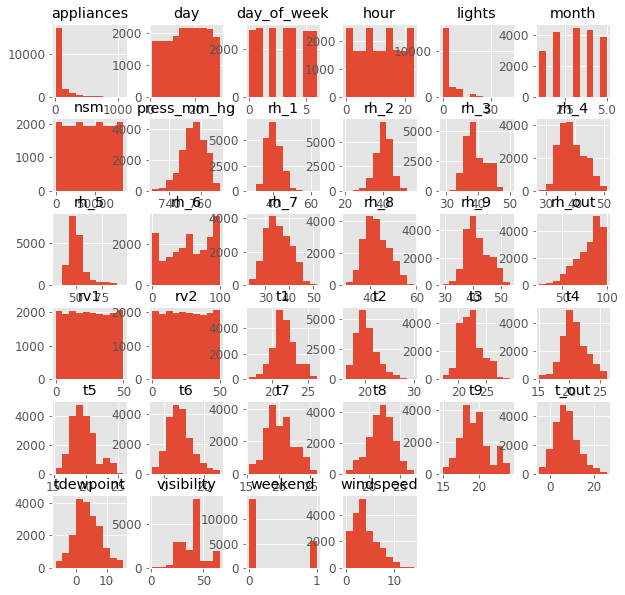

In [15]:
df_full.hist(figsize=(10,10));

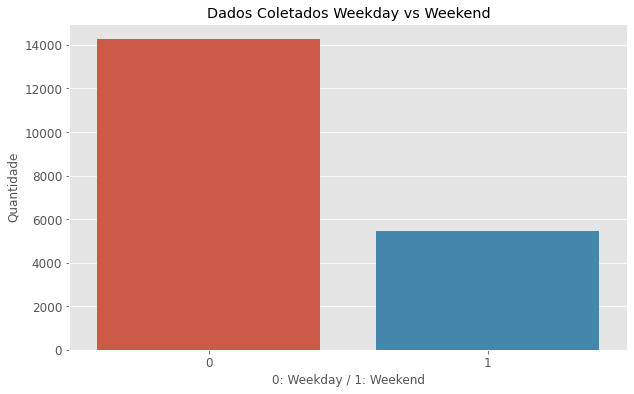

In [16]:
# Quantidade de dados coletados Weekend e WeekDay
fig, ax = plt.subplots(figsize = (10,6))

sns.countplot(df_full['weekend'])

ax.set_title('Dados Coletados Weekday vs Weekend')
ax.set_ylabel('Quantidade')
ax.set_xlabel('0: Weekday / 1: Weekend');

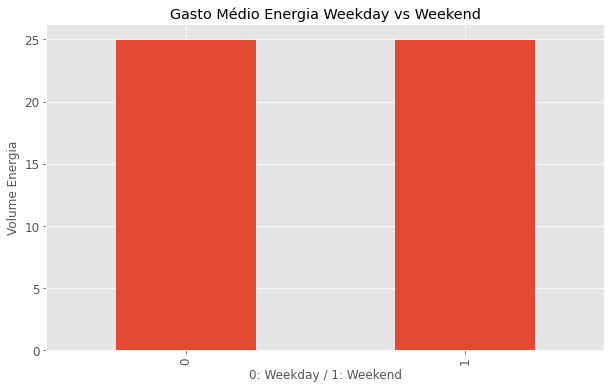

In [17]:
fig, ax = plt.subplots(figsize = (10,6))

df_full.groupby('weekend').mean()[column_target].plot(kind='bar')

ax.set_title('Gasto Médio Energia Weekday vs Weekend')
ax.set_ylabel('Volume Energia')
ax.set_xlabel('0: Weekday / 1: Weekend');

In [18]:
df_full.groupby('day_of_week').mean()[column_target]

day_of_week
0    24.337311
1    25.106401
2    25.294359
3    24.966591
4    25.247644
5    25.055579
6    24.886771
Name: rv1, dtype: float64

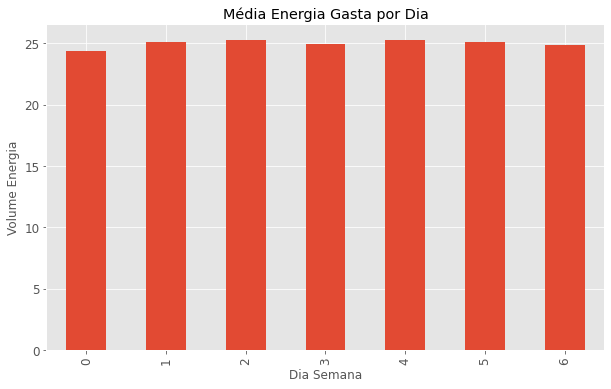

In [19]:
fig, ax = plt.subplots(figsize = (10,6))

df_full.groupby('day_of_week').mean()[column_target].plot(kind='bar')

ax.set_title('Média Energia Gasta por Dia')
ax.set_ylabel('Volume Energia')
ax.set_xlabel('Dia Semana');

O Gasto médio de energia no FDS e em dias de semana representam o mesmo gasto. Tomando como base que possui 5 dias Weekday e apenas 2 Weekend, o gasto nos FDS são relativamente maiores baseado na proporção da distribuição dos dados.

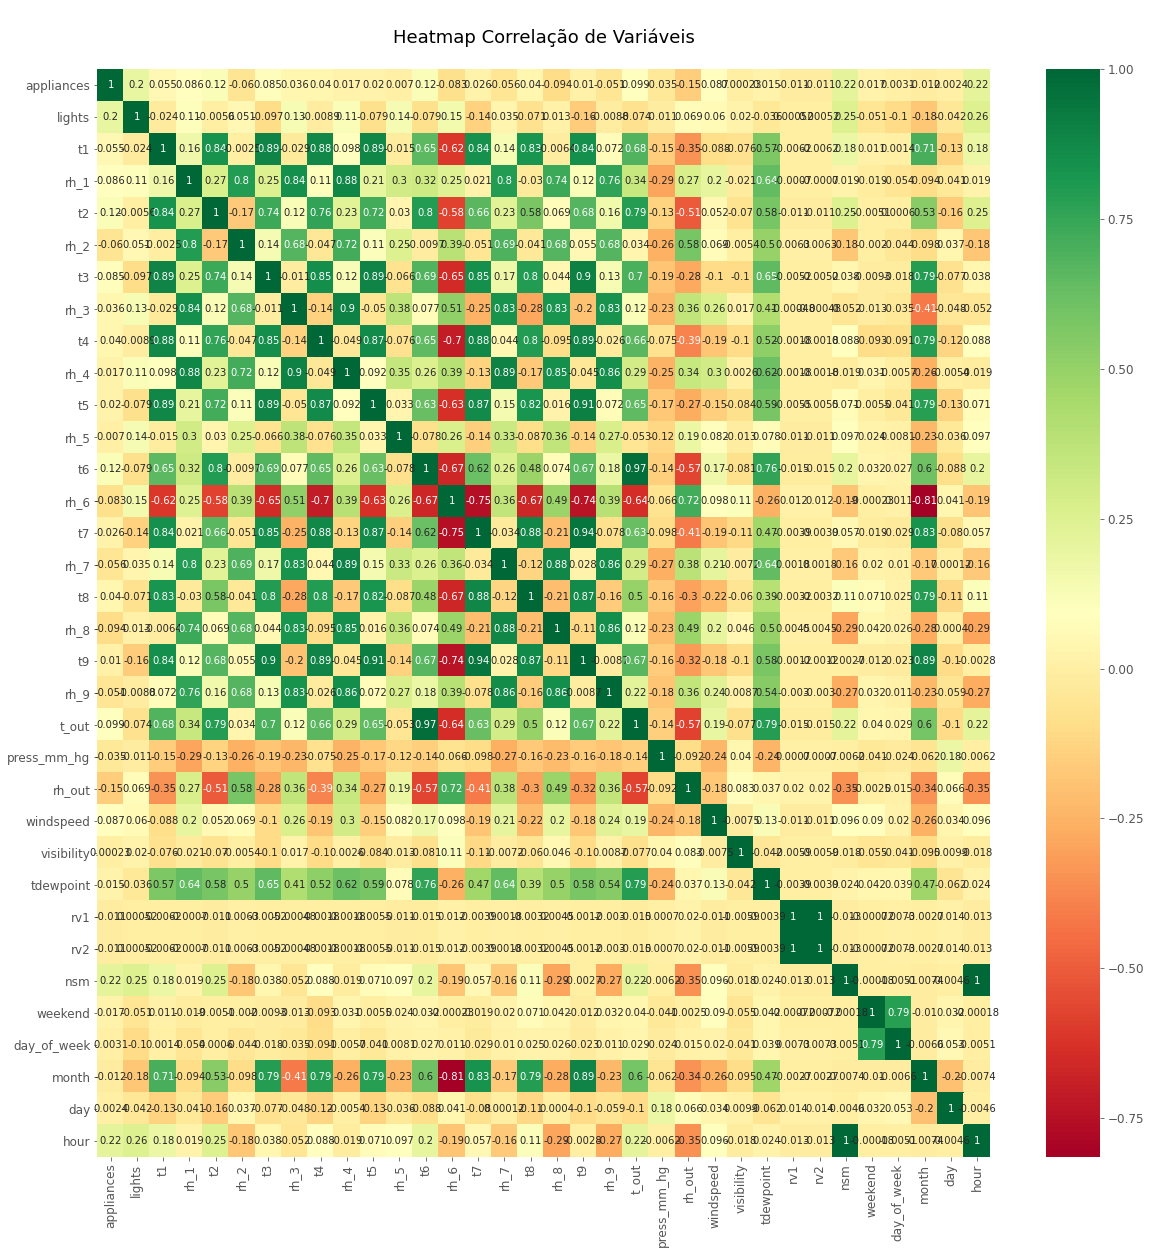

In [20]:
corrmat = df_full.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(20,20))
plt.title('\nHeatmap Correlação de Variáveis\n', fontsize=18)

g=sns.heatmap(df_full[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [21]:
# Variavel nsm e hour são altamente correlacionadas. Drop Coluna Hour.
df_train.drop('hour', axis=1, inplace=True)
df_test.drop('hour', axis=1, inplace=True)
df_full.drop('hour', axis=1, inplace=True)

In [22]:
# Variavel rv1 e rv2 são altamente correlacionadas e possuem a mesma informação. Vamos Dropar uma das colunas.
df_train.drop('rv2', axis=1, inplace=True)
df_test.drop('rv2', axis=1, inplace=True)
df_full.drop('rv2', axis=1, inplace=True)

In [23]:
# Definindo a variavel date como Index do Dataset. 
# Essa operação transforma os dados em séries possibilitando a análise como Series Temporais.
df_full.index = df_full['date']
df_full = df_full.drop('date', 1)
df_full.head(5)

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,...,rh_out,windspeed,visibility,tdewpoint,rv1,nsm,weekend,day_of_week,month,day
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,92.0,7.000000,63.000000,5.3,13.275433,61200,0,0,1,11
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,92.0,6.666667,59.166667,5.2,18.606195,61800,0,0,1,11
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,92.0,6.333333,55.333333,5.1,28.642668,62400,0,0,1,11
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,92.0,6.000000,51.500000,5.0,45.410389,63000,0,0,1,11
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,92.0,5.666667,47.666667,4.9,10.084097,63600,0,0,1,11


In [24]:
df_train.index = df_train['date']
df_train = df_train.drop('date', 1)

df_test.index = df_test['date']
df_test = df_test.drop('date', 1)

# Seleção de Atributos com Random Forest

In [25]:
# Utilizando Random Forest Regressor para identificar as melhores variáveis preditoras
X = df_full.loc[:, df_full.columns != column_target]
y = df_full.loc[:, df_full.columns == column_target]
model2 = RandomForestRegressor()
rfecv2 = RFECV(estimator=model2, cv=4)
m_rfecv = rfecv2.fit(X,y)

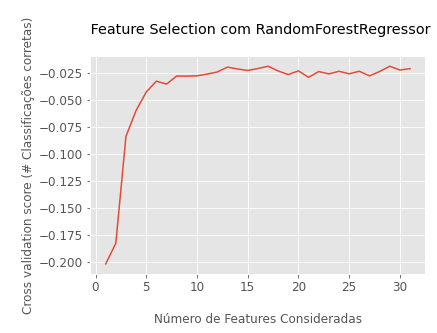


Variáveis Preditoras: Index(['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'nsm', 'weekend', 'day_of_week', 'month'],
      dtype='object')

Variáveis Selecionadas: [ True False False  True False  True False  True False  True False  True
  True  True False  True False  True False  True  True  True  True False
  True  True  True False False False False]

Ranking dos Atributos: [ 1 11  9  1  2  1  5  1  7  1  6  1  1  1  8  1  3  1 10  1  1  1  1  4
  1  1  1 15 13 14 12]

Número de Melhores Atributos: 17


In [27]:
# Plotando o resultado do feature selection com RandomForestRegressor
plt.figure()
plt.title("\n Feature Selection com RandomForestRegressor\n")
plt.xlabel("\nNúmero de Features Consideradas")
plt.ylabel("\nCross validation score (# Classificações corretas)")
plt.plot(range(1, len(m_rfecv.grid_scores_) + 1), m_rfecv.grid_scores_)
plt.show()

# Print dos resultados
print("\nVariáveis Preditoras:", X.columns[:-1])
print("\nVariáveis Selecionadas: %s" % m_rfecv.support_)
print("\nRanking dos Atributos: %s" % m_rfecv.ranking_)
print("\nNúmero de Melhores Atributos: %d" % m_rfecv.n_features_)

Apenas o dia da semana não foi considerado para ser utilizado como Variável Preditora.

# Análise Série Temporal

In [30]:
# Analisando Multicolinearidade entre os dados
vif = pd.DataFrame()
vif['Feature']= df_full.loc[:, df_full.columns != column_target].columns
vif['VIF Factor'] = [variance_inflation_factor(df_full.loc[:, df_full.columns != column_target].values, i) for i in range(df_full.loc[:, df_full.columns != column_target].shape[1])]

vif.round(1).head(100)

,Feature,VIF Factor
0,appliances,2.3
1,lights,1.6
2,t1,3705.4
3,rh_1,1716.4
4,t2,2536.8
5,rh_2,2206.4
6,t3,1373.1
7,rh_3,1645.0
8,t4,1071.8
9,rh_4,1457.0


In [31]:
# Pegando a data a cada X dias
def qtd_data(df_series, qtd):
    list_date = []
    control = 0
    
    for i in df_series.index.values:
        if control > qtd:
            control = 1        
    
        if control == 0 or control == qtd:
            list_date.append(i)
            control = control + 1
        else:
            control = control + 1        
    
    return list_date

### Realizando um agrupamento Diário para ter um paradigma de como está o consumo médio energia total.

In [32]:
df_full_series_Dia = df_full[column_target].resample('D').mean()

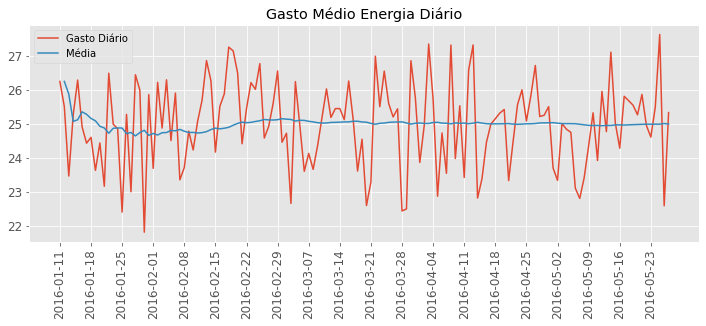

In [33]:
mean_ = [np.mean(df_full_series_Dia[:x]) for x in range(len(df_full_series_Dia))]
mean_series_Dia = pd.Series(mean_)
mean_series_Dia.index = df_full_series_Dia.index

fig, ax = plt.subplots(figsize = (12,4))
plt.plot(df_full_series_Dia, label = 'Gasto Diário')
plt.plot(mean_series_Dia, label = 'Média')
plt.legend()
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))

ax.set_title('Gasto Médio Energia Diário');

Podemos observar que a série de gasto Médio de Energia Diário possui uma média Constante. Vamos verificar se é uma série estacionária ou não utilizando o modelo de Dickey Fuller.

#### Vamos Decompor a Série em 3 partes: Tendência, Sazonalidade e Resíduo.

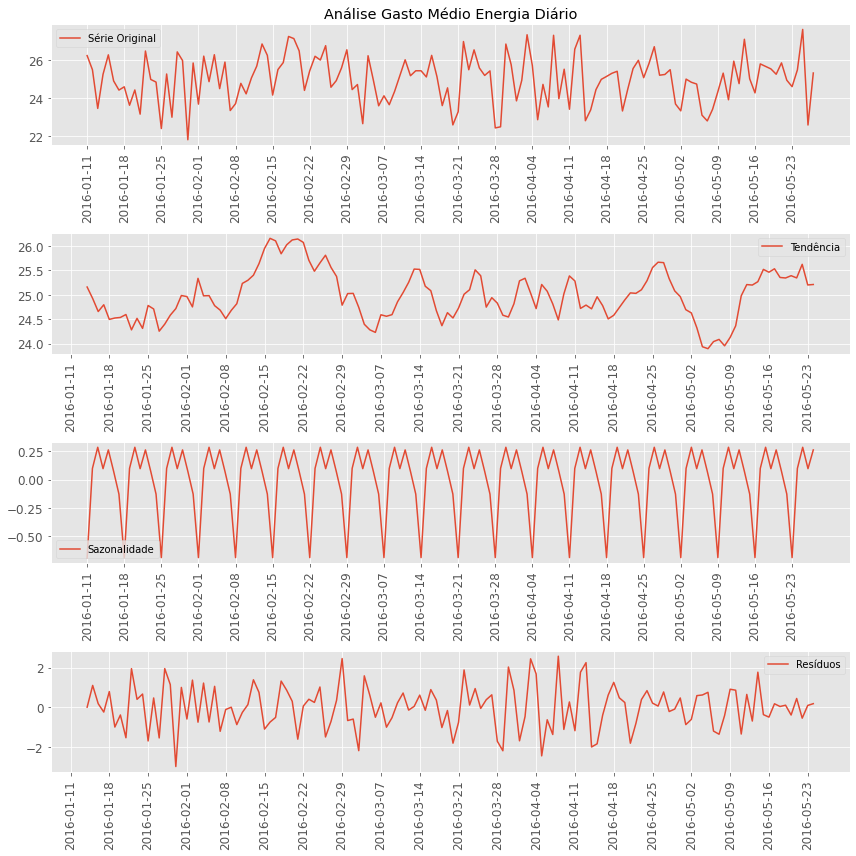

In [34]:
matplotlib.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,12))

res = seasonal_decompose(df_full_series_Dia)

plt.subplot(411)
plt.plot(res.observed, label = 'Série Original')
plt.legend(loc = 'best')
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))
plt.title('Análise Gasto Médio Energia Diário')

plt.subplot(412)
plt.plot(res.trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))

plt.subplot(413)
plt.plot(res.seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))

plt.subplot(414)
plt.plot(res.resid, label = 'Resíduos')
plt.legend(loc = 'best')
plt.xticks(rotation = 90)
plt.xticks(qtd_data(df_full_series_Dia, 7))

plt.tight_layout();

Observações:

- A Série não possui nenhuma tendência.
- Na Semana entre 08-02 até 22-02, parece ter ocorrido algum evento que elevou o gasto médio.
- Parece existir uma sazonalidade nos dados SEMANAL (a cada 7 dias), baseado em como o gráfico foi apresentado.
- Os Resíduos não seguem um padrão.

In [35]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie, tipo):
    if tipo is None:
        tipo = ''
    else:
        tipo = '('+tipo+')'
    
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão ' + tipo)
    plt.xticks(rotation = 45)
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

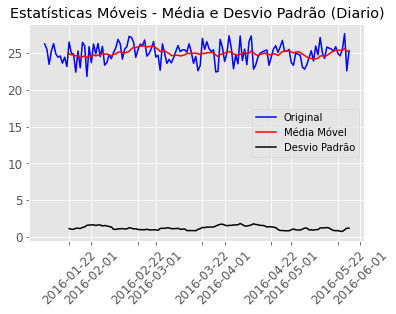


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -1.105909e+01
Valor-p                         4.860322e-20
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    1.370000e+02
Valor Crítico (1%)             -3.479007e+00
Valor Crítico (5%)             -2.882878e+00
Valor Crítico (10%)            -2.578149e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [36]:
testa_estacionaridade(df_full_series_Dia, 'Diario')

# Inicio Análise Preditiva

O resultado da decomposição da Série nos mostra que existe sazonalidade no conjunto de dados. Devido a esse fator, iremos realizar o primeiro treinamento do modelo utilizando o modelo **SARIMA**.

In [37]:
df_train.shape[0]

14803

In [38]:
df_test.shape

(4932, 32)

In [39]:
# Split do df_full em 2 novos dfs:
# Irei substituir as informações no df_train e df_test, porém deixando os dados com a msm qtd q antes.
df_train = df_full.iloc[0:df_train.shape[0]+1]
df_test = df_full.iloc[df_train.shape[0]: ]

In [40]:
df_train_series_Dia = df_train[column_target].resample('D').mean()
df_test_series_Dia = df_test[column_target].resample('D').mean()

In [41]:
# Função para medir o desempenho do modelo
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

In [42]:
# Vamos definir p, d e q para que tenham valores entre 0 e 2 e testaremos as combinações.
p = d = q = range(0, 2)
# Lista de combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [43]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
# Estamos usando List Comprehension
# 7 representa a sazonalidade
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7)]

In [44]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 1) x (1, 0, 0, 7)


In [46]:
# Grid Search
#warnings.filterwarnings("ignore")

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    
    for param_seasonal in seasonal_pdq:
        try:
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(df_train_series_Dia,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:957.6535340232277
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:788.7999225572698
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:393.6582621025351
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:321.33577945077974
SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:399.38773005724215
SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:348.8034958803563
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:350.40530653752955
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:326.7864144947123
SARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:819.4122404745002
SARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:679.9782108542289
SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:391.42565078976264
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:320.58721241074284
SARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:401.14961875390037
SARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:348.04340825124075
SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:351.8342630627755
SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:324.9123296735849
SARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:413.175871890644
SARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:390.348177537792
SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:451.47

In [47]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima = sm.tsa.statespace.SARIMAX(df_train_series_Dia,
                                             order = (0, 0, 1),
                                             seasonal_order = (0, 1, 1, 7),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

In [48]:
# Treinamento (Fit) do modelo
modelo_sarima_fit = modelo_sarima.fit()

In [49]:
# Sumário do modelo
print(modelo_sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               rv1   No. Observations:                  104
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood                -157.294
Date:                           Thu, 16 Jul 2020   AIC                            320.587
Time:                                   16:11:45   BIC                            328.019
Sample:                               01-11-2016   HQIC                           323.581
                                    - 04-23-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0639      0.113      0.567      0.570      -0.157       0.284
ma.S.L7       -0.8692      0.130     -6.709

In [50]:
df_test_series_Dia.index.values.min()

numpy.datetime64('2016-04-23T00:00:00.000000000')

In [51]:
df_test_series_Dia.index.values.max()

numpy.datetime64('2016-05-27T00:00:00.000000000')

In [52]:
# Vamos fazer previsões dos dados do TESTE
sarima_predict = modelo_sarima_fit.get_prediction(start = pd.to_datetime('2016-04-23'), 
                                                       end = pd.to_datetime('2016-05-27'),
                                                       dynamic = False)

In [53]:
# Intervalo de confiança
sarima_predict_conf = sarima_predict.conf_int()
sarima_predict_conf

,lower rv1,upper rv1
2016-04-23,22.064487,27.560629
2016-04-24,22.513234,28.009377
2016-04-25,21.591043,27.098378
2016-04-26,22.162595,27.669917
2016-04-27,22.700290,28.204275
2016-04-28,21.941968,27.445952
2016-04-29,22.429862,27.933846
2016-04-30,22.450084,27.954069
2016-05-01,22.341046,27.894845
2016-05-02,21.567710,27.121711


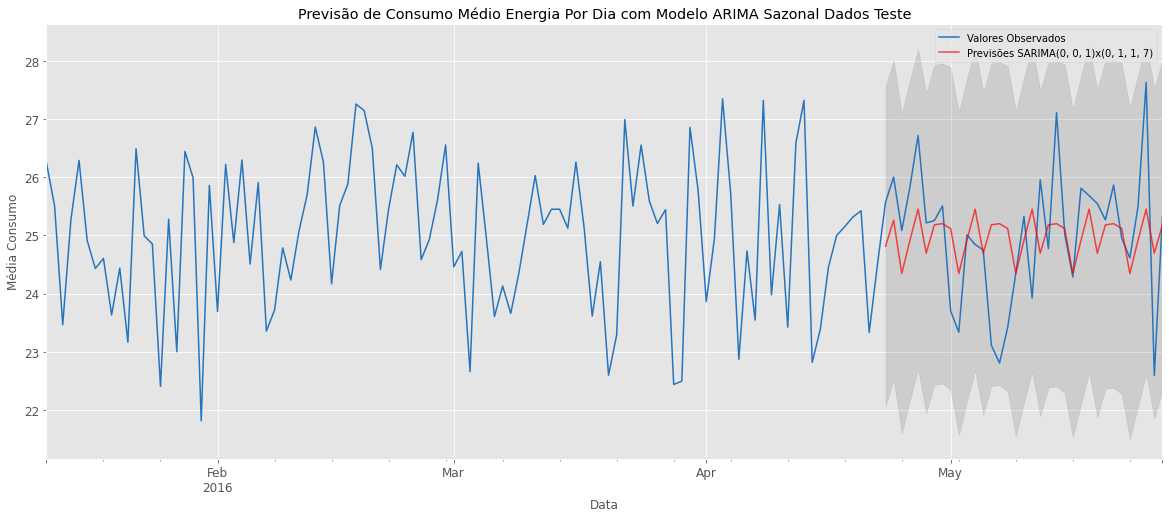

In [54]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = df_full_series_Dia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA(0, 0, 1)x(0, 1, 1, 7)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf.index,
                # lower sales
                sarima_predict_conf.iloc[:, 0],
                # upper sales
                sarima_predict_conf.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Consumo Médio Energia Por Dia com Modelo ARIMA Sazonal Dados Teste')
plt.xlabel('Data')
plt.ylabel('Média Consumo')
plt.legend()
plt.show()

### Compreendendo o resultado:

- Azul: A série completa (df_full_series_Dia)

- Vermelho: Dados Previstos pelo modelo.

Foi informado dados do df_test_series_Dia para o modelo aplicar a previsão.

In [55]:
# Calculando a performance
sarima_results_treino = performance(df_test_series_Dia, sarima_predict.predicted_mean)
sarima_results_treino

MSE das previsões é 1.18
RMSE das previsões é 1.09
MAPE das previsões é 3.35


# MODELO SARIMA COM VARIÁVEL EXÓGENA

In [56]:
feriados = pd.Series()

# Como nosso dataset aparenta ser da Bélgica, baseado na informação do aeroporto, estamos procurando feriados no ano.
for i, feriado in holidays.Belgium(years = [2016]).items():
    feriados[i] = feriado

In [57]:
feriados_df = pd.DataFrame(feriados)

In [58]:
# Reset do index para ajustar os nomes das colunas
feriados_df.reset_index(level = 0, inplace = True)
feriados_df.columns = ['data_feriado', 'feriado']
# Visualiza
feriados_df.head()
feriados_df['data_feriado'] = pd.to_datetime(feriados_df['data_feriado'])

In [59]:
# Função
def adiciona_feriado(x):
    
    # Aplica a regra
    batch_df = feriados_df.apply(lambda y: 1 if (x['data'] == y['data_feriado']) else None, axis=1)
    
    # Limpa valores nulos
    batch_df = batch_df.dropna(axis = 0, how = 'all')  
    
    # Se estiver vazio, preenche com 0
    if batch_df.empty:
        batch_df = 0
    else: 
        batch_df = batch_df.to_string(index = False)
        
    return batch_df

In [60]:
# Cria um dataframe a partir da série
Frame_means = pd.DataFrame(df_train_series_Dia)

# Reset do índice para ajustar as colunas (podia ter feito tudo isso em um comando, ms didaticamente deixamos assim)
Frame_means.reset_index(level = 0, inplace = True)

# Ajusta o nome das colunas
Frame_means.columns = ['data', 'rv1']
Frame_means.head()

# Aplicamos a função e criamos a coluna feriado
Frame_means['feriado'] = Frame_means.apply(adiciona_feriado, axis = 1)

# Convertendo a coluna feriado para inteiro
Frame_means['feriado'] = pd.to_numeric(Frame_means['feriado'], downcast = 'integer')

# Vamos definir a order_date como índice
Frame_means.set_index("data", inplace = True)

In [61]:
df_train.columns

Index(['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'rv1', 'nsm', 'weekend', 'day_of_week', 'month', 'day'],
      dtype='object')

In [62]:
# E somente o feriado (mais uma constante requerida pelo statsmodels) na série de feriado
exog_var_treino = sm.add_constant(Frame_means['feriado'])
exog_var_treino

,const,feriado
data,,
2016-01-11,1.0,0
2016-01-12,1.0,0
2016-01-13,1.0,0
2016-01-14,1.0,0
2016-01-15,1.0,0
...,...,...
2016-04-19,1.0,0
2016-04-20,1.0,0
2016-04-21,1.0,0


In [63]:
# Grid Search
warnings.filterwarnings("ignore")

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(df_train_series_Dia,
                                            exog_var_treino,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:351.6749352036513
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:334.1854024568848
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:396.9217071333301
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:324.6279229412292
SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:336.696661933733
SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:331.8870710439734
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:353.4248796899563
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:330.009320270419
SARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:351.16756349794093
SARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:332.66856419389603
SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:394.77889100519633
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:324.02252747903844
SARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC:338.6920808218458
SARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC:331.17545021938105
SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:355.0887601517098
SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:328.2505289586875
SARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:417.170928833825
SARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:394.3429367776217
SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:455.44852

In [64]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(df_train_series_Dia,
                                             exog_var_treino,
                                             order = (0, 0, 1),
                                             seasonal_order = (0, 1, 1, 7),
                                             enforce_stationarity = False,
                                             enforce_invertibility=False)

In [65]:
# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [66]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               rv1   No. Observations:                  104
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood                -157.011
Date:                           Thu, 16 Jul 2020   AIC                            324.023
Time:                                   16:12:47   BIC                            336.409
Sample:                               01-11-2016   HQIC                           329.013
                                    - 04-23-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.023e-06   1.01e+06   1.01e-12      1.000   -1.98e+06    1.98e+06
feriado       -0.7619      0.938     -0.812

In [67]:
df_train_series_Dia.index.values.min()

numpy.datetime64('2016-01-11T00:00:00.000000000')

In [68]:
df_train_series_Dia.index.values.max()

numpy.datetime64('2016-04-23T00:00:00.000000000')

In [69]:
# Vamos fazer previsões um passo a frente
sarima_predict_2_treino = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2016-01-20'), 
                                                       end = pd.to_datetime('2016-04-23'),
                                                       exog = exog_var_treino, #['20160111':'20160527'],
                                                       dynamic = True)
# Intervalo de confiança
sarima_predict_conf_2_treino = sarima_predict_2_treino.conf_int()
sarima_predict_conf_2_treino

,lower rv1,upper rv1
2016-01-20,19.844874,27.084533
2016-01-21,21.644716,28.884376
2016-01-22,22.669662,29.909321
2016-01-23,21.292860,28.532520
2016-01-24,20.811844,28.051504
...,...,...
2016-04-19,19.789665,27.474020
2016-04-20,19.604575,27.324832
2016-04-21,21.404417,29.124675
2016-04-22,22.429362,30.149620


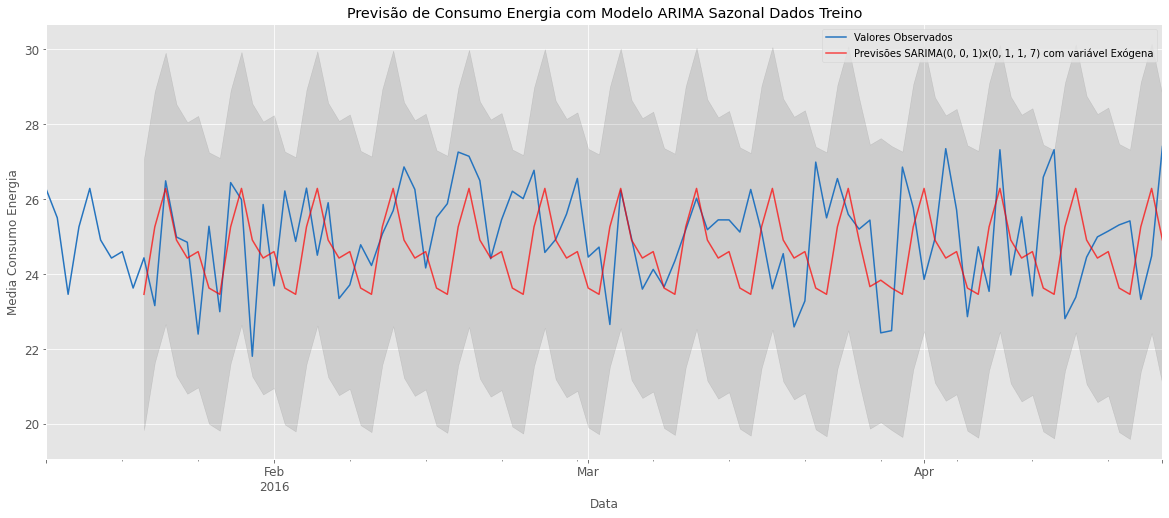

In [72]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = df_train_series_Dia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict_2_treino.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA(0, 0, 1)x(0, 1, 1, 7) com variável Exógena', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf_2_treino.index,
                # lower sales
                sarima_predict_conf_2_treino.iloc[:, 0],
                # upper sales
                sarima_predict_conf_2_treino.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Consumo Energia com Modelo ARIMA Sazonal Dados Treino')
plt.xlabel('Data')
plt.ylabel('Media Consumo Energia')
plt.legend()
plt.show()

In [73]:
# Calculando a performance Dados Treino
sarima_results_2_treino = performance(df_train_series_Dia, sarima_predict_2_treino.predicted_mean)
sarima_results_2_treino

MSE das previsões é 2.62
RMSE das previsões é 1.62
MAPE das previsões é 5.34


In [74]:
# Cria um dataframe a partir da série
Frame_means_teste = pd.DataFrame(df_test_series_Dia)

# Reset do índice para ajustar as colunas (podia ter feito tudo isso em um comando, ms didaticamente deixamos assim)
Frame_means_teste.reset_index(level = 0, inplace = True)

# Ajusta o nome das colunas
Frame_means_teste.columns = ['data', 'rv1']
Frame_means_teste.head()

# Aplicamos a função e criamos a coluna feriado
Frame_means_teste['feriado'] = Frame_means_teste.apply(adiciona_feriado, axis = 1)

# Convertendo a coluna feriado para inteiro
Frame_means_teste['feriado'] = pd.to_numeric(Frame_means_teste['feriado'], downcast = 'integer')

# Vamos definir a order_date como índice
Frame_means_teste.set_index("data", inplace = True)

In [75]:
# E somente o feriado (mais uma constante requerida pelo statsmodels) na série de feriado
exog_var_teste = sm.add_constant(Frame_means_teste['feriado'])
exog_var_teste

,const,feriado
data,,
2016-04-23,1.0,0
2016-04-24,1.0,0
2016-04-25,1.0,0
2016-04-26,1.0,0
2016-04-27,1.0,0
2016-04-28,1.0,0
2016-04-29,1.0,0
2016-04-30,1.0,0
2016-05-01,1.0,1


In [76]:
exog_var_teste.shape

(35, 2)

In [77]:
df_test_series_Dia.shape

(35,)

In [78]:
df_test_series_Dia.index.values.min()

numpy.datetime64('2016-04-23T00:00:00.000000000')

In [79]:
df_test_series_Dia.index.values.max()

numpy.datetime64('2016-05-27T00:00:00.000000000')

In [80]:
# Vamos fazer previsões um passo a frente
sarima_predict_2_teste = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2016-04-24'), 
                                                       end = pd.to_datetime('2016-05-27'),
                                                       exog = exog_var_teste['20160424':'20160527'],
                                                       dynamic = True)
# Intervalo de confiança
sarima_predict_conf_2_teste = sarima_predict_2_teste.conf_int()
sarima_predict_conf_2_teste

,lower rv1,upper rv1
2016-04-24,22.558873,28.041713
2016-04-25,21.673703,27.163073
2016-04-26,22.171992,27.661355
2016-04-27,22.726298,28.212635
2016-04-28,21.930568,27.416906
2016-04-29,22.425085,27.911423
2016-04-30,22.465281,27.951618
2016-05-01,21.659795,27.199186
2016-05-02,21.648630,27.188146
2016-05-03,22.146919,27.686428


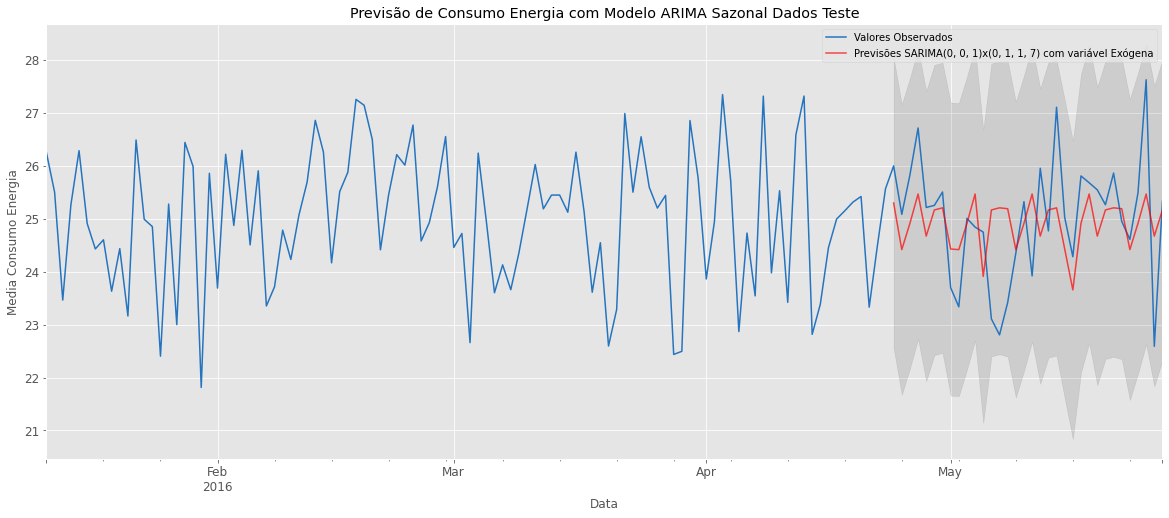

In [81]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = df_full_series_Dia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict_2_teste.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA(0, 0, 1)x(0, 1, 1, 7) com variável Exógena', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf_2_teste.index,
                # lower sales
                sarima_predict_conf_2_teste.iloc[:, 0],
                # upper sales
                sarima_predict_conf_2_teste.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Consumo Energia com Modelo ARIMA Sazonal Dados Teste')
plt.xlabel('Data')
plt.ylabel('Media Consumo Energia')
plt.legend()
plt.show()

In [82]:
# Calculando a performance Dados Teste
sarima_results_2_teste = performance(df_test_series_Dia, sarima_predict_2_teste.predicted_mean)
sarima_results_2_teste

MSE das previsões é 1.17
RMSE das previsões é 1.08
MAPE das previsões é 3.46


# Análise Parcial:

##### Comparando o resultado nos dados de Teste do Modelo SARIMA x Modelo SARIMA Com Variável Exógena, o resultado foi:

- Modelo SARIMA: MSE: 1.19 | RMSE: 1.09 | MAPE: 3.37 | AIC: 321.170
- Modelo SARIMA Com Variável Exógena: MSE: 1.17 | RMSE: 1.08 | MAPE: 3.45 | AIC: 324.607

Com A variável Exógena de Feriados na Bélgica tivemos um aumento do AIC. O resultado não foi tão bom.

Se fosse necessário escolher entre os 2 modelos acima, o modelo escolhido seria o SARIMA com menor AIC.

# MODELO VAR MULTIVARIADO

In [83]:
df_train_Dia_mean = df_train.resample('D').mean()
df_test_Dia_mean = df_test.resample('D').mean()

In [84]:
df_train_Dia_mean.describe()

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,...,rh_out,windspeed,visibility,tdewpoint,rv1,nsm,weekend,day_of_week,month,day
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,...,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,99.115486,4.585300,21.140227,40.312856,19.663193,40.751045,21.544638,39.642328,20.118548,39.234179,...,81.899043,4.314488,38.775896,2.804400,25.010056,42992.307692,0.278846,2.971154,2.538462,15.846154
std,31.416163,4.102903,1.030966,3.213552,1.097036,2.759581,1.423828,2.995280,1.392975,4.108453,...,7.609773,2.101178,4.911099,3.309792,1.310037,3655.656405,0.450603,1.997361,1.051334,8.367493
min,37.500000,0.000000,17.474103,34.448223,16.730961,34.688981,17.582789,34.994659,15.356111,32.714149,...,59.881944,1.000000,29.576389,-5.645139,21.812393,21900.000000,0.000000,0.000000,1.000000,1.000000
25%,77.829861,2.135417,20.534149,38.068313,18.899154,38.805065,20.599294,37.359398,19.290530,35.771871,...,77.617188,2.741319,35.539062,0.602170,24.158756,42900.000000,0.000000,1.000000,2.000000,9.000000
50%,92.986111,3.819444,21.334413,39.729931,19.571412,40.789777,21.437758,38.886001,20.223840,38.829809,...,82.265625,4.112847,38.500000,2.968229,25.131771,42900.000000,0.000000,3.000000,3.000000,16.000000
75%,118.159722,5.833333,21.922682,43.048111,20.450793,42.773038,22.570256,41.930788,21.064912,42.378226,...,87.377604,5.617188,41.543403,5.102257,25.996847,42900.000000,1.000000,5.000000,3.000000,22.250000
max,188.541667,30.000000,22.644508,46.974225,21.663038,45.745376,25.014757,46.173738,22.845324,49.107610,...,97.069444,10.631944,58.600694,10.375347,27.408239,73500.000000,1.000000,6.000000,4.000000,31.000000


In [85]:
df_train_Dia_mean_Stand = df_train_Dia_mean.copy()

# Colunas que desejo aplicar a Padronização
cols = ['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'nsm']

for i in cols:
    scale = StandardScaler().fit(df_train_Dia_mean[[i]])
    
    df_train_Dia_mean_Stand[i] = scale.transform(df_train_Dia_mean[[i]])

df_train_Dia_mean_Stand.head(2)

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,...,rh_out,windspeed,visibility,tdewpoint,rv1,nsm,weekend,day_of_week,month,day
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11,1.201071,6.224319,-0.323252,2.061670,0.44895,1.471855,-0.990613,2.130306,-0.451809,1.963149,...,0.975383,0.845912,0.423401,0.432374,26.248800,8.385753,0.0,0.0,1.0,11.0
2016-01-12,-0.429271,-0.085520,-1.021348,1.510025,-0.32566,1.102832,-1.094586,1.774948,-0.249426,1.301813,...,0.739586,0.703108,-0.316471,0.240488,25.505072,-0.025373,0.0,1.0,1.0,12.0


In [86]:
df_test_Dia_mean_Stand = df_test_Dia_mean.copy()

# Colunas que desejo aplicar a Padronização
cols = ['appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint', 'nsm']

for i in cols:
    scale = StandardScaler().fit(df_test_Dia_mean[[i]])
    
    df_test_Dia_mean_Stand[i] = scale.transform(df_test_Dia_mean[[i]])

df_test_Dia_mean_Stand.head(2)

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,...,rh_out,windspeed,visibility,tdewpoint,rv1,nsm,weekend,day_of_week,month,day
date,,,,,,,,,,,,,,,,,,,,,
2016-04-23,0.516117,-0.390213,-0.397016,-0.693922,-0.706359,-0.684018,-0.258013,-1.194030,-0.415493,-1.271432,...,-1.386467,1.993041,0.821486,-1.662684,23.623438,5.284689,1.0,5.0,4.0,23.0
2016-04-24,-0.483022,-0.370584,-1.158510,-0.919790,-1.644691,-0.234403,-0.995647,-1.125813,-0.875610,-1.184571,...,0.956496,0.075986,0.188025,-1.233242,26.001043,-0.080793,1.0,6.0,4.0,24.0


In [87]:
model = VAR(endog = df_train_Dia_mean_Stand,
            freq = df_train_Dia_mean_Stand.index.inferred_freq)

model_fit = model.fit()

In [88]:
# model_fit.plot_forecast(3);
df_test_Dia_mean_Stand.values.shape

(35, 32)

In [89]:
pred_var = model_fit.forecast(y=df_test_Dia_mean_Stand.values, steps=35)
pred_var

array([[-2.5749103 ,  0.63223724,  0.3802065 , ...,  0.60207875,
         5.32587128, 18.05216013],
       [-1.31078852,  0.22984462,  0.53621524, ...,  3.8978233 ,
         5.5959771 , 10.61921941],
       [-0.65985821, -1.14009344,  0.82885578, ...,  3.82885795,
         5.58075911, 11.87351597],
       ...,
       [ 0.05953641, -0.79784223,  2.35083565, ...,  3.00717116,
         6.68394073,  9.55117468],
       [ 0.0594995 , -0.8056826 ,  2.37261338, ...,  3.00725053,
         6.71785559,  9.56204225],
       [ 0.05958601, -0.81308755,  2.39447357, ...,  3.00743119,
         6.75228492,  9.55697596]])

In [90]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Jul, 2020
Time:                     16:13:50
--------------------------------------------------------------------
No. of Equations:         32.0000    BIC:                   -54.4550
Nobs:                     103.000    HQIC:                  -70.5264
Log likelihood:           574.746    FPE:                8.79336e-36
AIC:                     -81.4673    Det(Omega_mle):     1.20698e-39
--------------------------------------------------------------------
Results for equation appliances
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  1.499308         2.869622            0.522           0.601
L1.appliances         -0.077550         0.173446           -0.447           0.655
L1.lights              0.209155         0.221358   

In [91]:
pred = pd.DataFrame(index=range(0,len(pred_var)),columns=[df_train_Dia_mean_Stand.columns])
pred

#len(pred_var)

for j in range(0,len(df_train_Dia_mean_Stand.columns)):
    for i in range(0, len(pred_var)):
        pred.iloc[i][j] = pred_var[i][j]

In [92]:
df_forecast = pd.DataFrame(pred_var, index=df_test_Dia_mean_Stand.index, columns=df_test_Dia_mean_Stand.columns + '_2d')

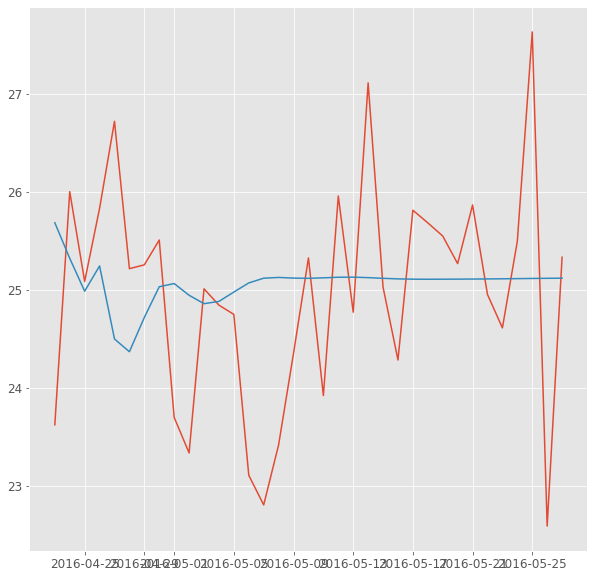

In [93]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(df_test_Dia_mean_Stand['rv1'])
ax.plot(df_forecast['rv1_2d']);

In [94]:
performance(df_forecast['rv1_2d'], df_test_Dia_mean_Stand['rv1'])

MSE das previsões é 1.43
RMSE das previsões é 1.2
MAPE das previsões é 3.65


## Modelo VAR com Multivariaveis não foi capaz de prever o consumo médio de energia Diário. Resultado muito ruim.

## Irei realizar o estudo agora utilizando o Modelo Gradient Boosting para prever o consumo médio de energia Diário.

## GRADIENT BOOSTING

In [95]:
#X = df_full.loc[:, df_full.columns != column_target]
#y = df_full.loc[:, df_full.columns == column_target]

X_train = df_train_Dia_mean_Stand.loc[:, df_train_Dia_mean_Stand.columns != column_target]
Y_train = df_train_Dia_mean_Stand.loc[:, df_train_Dia_mean_Stand.columns == column_target]

X_test = df_test_Dia_mean_Stand.loc[:, df_test_Dia_mean_Stand.columns != column_target]
Y_test = df_test_Dia_mean_Stand.loc[:, df_test_Dia_mean_Stand.columns == column_target]

In [96]:
X_train.shape
#Y_train.shape

(104, 31)

In [97]:
X_test.shape
#Y_test.shape

(35, 31)

In [98]:
# GRID SEARCH para identificar os melhores parametros.

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [4, 5, 6],
              'min_samples_leaf': [3, 4, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [400, 700, 1000, 2000, 3000]
              }

# Regressor
est = GradientBoostingRegressor()

# Modelo criado com GridSearchCV
gs_cv = GridSearchCV(est, param_grid, scoring = 'neg_mean_squared_error', n_jobs = 4, return_train_score=True).fit(X_train, Y_train)

# Imprime os melhors parâmetros
print('Melhores Hiperparâmetros: %r' % gs_cv.best_params_)

Melhores Hiperparâmetros: {'learning_rate': 0.001, 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 400, 'subsample': 0.3}


In [99]:
gs_cv.best_params_

{'learning_rate': 0.001,
 'max_depth': 6,
 'min_samples_leaf': 4,
 'n_estimators': 400,
 'subsample': 0.3}

In [ ]:
#est = GradientBoostingRegressor()

#params = {'min_samples_leaf': 3}
#est.set_params(**gs_cv.best_params_)
#est.fit(X_train, Y_train)

In [100]:
est = GradientBoostingRegressor(n_estimators = 6000, max_depth =8, learning_rate = 0.001, min_samples_leaf=4, subsample=0.3)
est.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=8, min_samples_leaf=4,
                          n_estimators=6000, subsample=0.3)

In [101]:
yhat = est.predict(X_test)
yhat

array([25.26795945, 25.07787568, 24.21702102, 24.37397624, 24.11762018,
       25.47092927, 25.22225477, 25.56574452, 24.96682548, 24.37524666,
       25.05417378, 25.04234656, 25.46110517, 25.84463358, 24.93839214,
       25.15051707, 24.8964805 , 24.38745047, 24.49279478, 24.47581186,
       23.85417182, 24.38604305, 25.18528317, 24.89780266, 25.73479829,
       25.02981979, 25.22622985, 25.33380259, 24.84541629, 24.83078461,
       25.41410786, 25.19334052, 25.29558919, 25.53306016, 25.29706047])

In [103]:
predy = pd.DataFrame(index=range(0,len(yhat)), columns=['rv1_pred'])

j = 0
for i in range(0, len(yhat)):
    predy.iloc[i][j] = yhat[i]

In [104]:
predy

,rv1_pred
0,25.268
1,25.0779
2,24.217
3,24.374
4,24.1176
5,25.4709
6,25.2223
7,25.5657
8,24.9668
9,24.3752


In [105]:
predy.index = Y_test.index

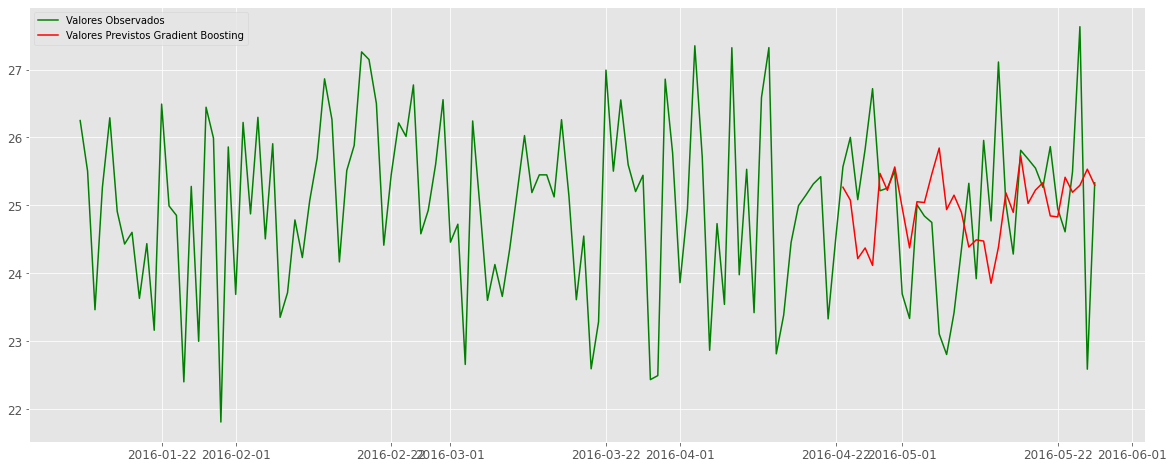

In [106]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(df_full_series_Dia, color = "green", label = 'Valores Observados')
ax.plot(pd.Series(predy['rv1_pred']), color = 'red', label = 'Valores Previstos Gradient Boosting')
plt.legend();

In [107]:
performance(pd.Series(predy['rv1_pred']), pd.Series(Y_test['rv1']))

MSE das previsões é 1.72
RMSE das previsões é 1.31
MAPE das previsões é 3.94


### REGRESSÃO LINEAR MULTILA

In [108]:
X_train = df_train_Dia_mean_Stand.loc[:, df_train_Dia_mean_Stand.columns != column_target]
Y_train = df_train_Dia_mean_Stand.loc[:, df_train_Dia_mean_Stand.columns == column_target]

X_test = df_test_Dia_mean_Stand.loc[:, df_test_Dia_mean_Stand.columns != column_target]
Y_test = df_test_Dia_mean_Stand.loc[:, df_test_Dia_mean_Stand.columns == column_target]

In [109]:
modelo = LinearRegression()
modelo_result = modelo.fit(X_train, Y_train)

In [110]:
yhat2 = modelo_result.predict(X_test)

In [111]:
# output list  
# function used for removing nested  
# lists in python.  
def reemovNestings(yhat2): 
    
    for i in yhat2: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            output.append(i) 
    
    return output

In [112]:
output = []
yhat2 = reemovNestings(yhat2.tolist())

In [113]:
yhat2

[21.464520509132576,
 24.60136037063396,
 25.963761592380894,
 23.780144228368847,
 25.54254061071477,
 25.70977098938882,
 25.76762026976683,
 25.084965709888003,
 23.714655412945103,
 23.837472490635847,
 23.930628697678316,
 23.974592870997803,
 22.99985163431309,
 25.80401710950495,
 22.804461667825827,
 23.35308623392466,
 26.989247909043307,
 24.406818447019525,
 24.17998388058447,
 25.244304575283,
 25.590062263248655,
 23.139146608106433,
 25.38264800503939,
 24.406909445904784,
 27.132619922118245,
 26.725557315512116,
 25.976641798964835,
 27.061316129516417,
 24.530821065078662,
 24.870436261128226,
 24.429057064860224,
 25.7419425452679,
 28.420475167104307,
 26.742801095609426,
 27.69412981304624]

In [114]:
predy2 = pd.DataFrame(index=range(0,len(yhat2)), columns=['rv1_pred'])

j = 0
for i in range(0, len(yhat2)):
    predy2.iloc[i][j] = yhat2[i]

In [115]:
predy2.index = Y_test.index

In [116]:
predy2

,rv1_pred
date,
2016-04-23,21.4645
2016-04-24,24.6014
2016-04-25,25.9638
2016-04-26,23.7801
2016-04-27,25.5425
2016-04-28,25.7098
2016-04-29,25.7676
2016-04-30,25.085
2016-05-01,23.7147


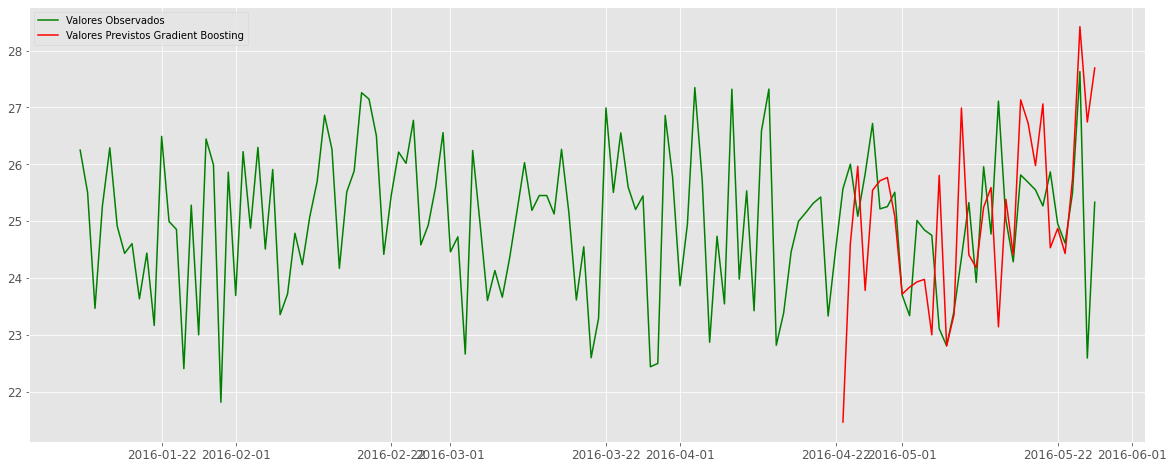

In [117]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(df_full_series_Dia, color = "green", label = 'Valores Observados')
ax.plot(pd.Series(predy2['rv1_pred']), color = 'red', label = 'Valores Previstos Gradient Boosting')
plt.legend();

In [118]:
performance(pd.Series(predy2['rv1_pred']), pd.Series(Y_test['rv1']))

MSE das previsões é 2.36
RMSE das previsões é 1.54
MAPE das previsões é 4.5


# Avaliando todos os resultados.


SARIMA

- AIC:320.58721241074284
- MSE das previsões é 1.18
- RMSE das previsões é 1.09
- MAPE das previsões é 3.35

SARIMA COM VARIAVEL EXÓGENA

- AIC:324.02252747903844
- MSE das previsões é 1.17
- RMSE das previsões é 1.08
- MAPE das previsões é 3.46

VAR MULTIVARIAVEL

- MSE das previsões é 1.43
- RMSE das previsões é 1.2
- MAPE das previsões é 3.65

GRADIENT BOOSTING REGRESSOR

- MSE das previsões é 1.72
- RMSE das previsões é 1.31
- MAPE das previsões é 3.94

REGRESSÃO LINEAR

- MSE das previsões é 2.36
- RMSE das previsões é 1.54
- MAPE das previsões é 4.5

### Diante o Cenário, caso o objetivo seja prever o consumo em um determinado dia, seria utilizado o Modelo SARIMA, pois o SARIMA com Variável Exógena, não apresentou um ganho representativo e teve uma queda no AIC.

### Caso o objetivo seja prever o consumo diário sem levar em conta um dia especifico, o Modelo Gradient Boosting seria melhor recomendado devido a taxa do RMSE ser relativamente menor.